In [ ]:
# Sentinel-1 Data

This notebook aims to test some Data Cube functions using Sentinel-1 data

First... we do all the necessary imports !

In [1]:
%matplotlib inline
# necessary for plot display in jupyter

from datetime import date
import json
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import numpy
import time
from datacube.api.model import DatasetType, Satellite, BANDS, SMOSBands
from datacube.api.query import list_tiles_as_list
from datacube.api.utils import get_dataset_data, get_dataset_metadata
from eotools.tiling import generate_tiles
from eotools.coordinates import convert_coordinates
from idl_functions import histogram
from math import log10
from scipy import optimize
from scipy import interpolate
from scipy import signal
#import ogr
#import pandas
#from idl_functions import hist_equal
#from idl_functions import label_region
#from image_processing.segmentation import SegmentVisitor

In [2]:
import sys

def my_print(text):
    sys.stdout.write(str(text))
    sys.stdout.flush()

#### We define all the parameters we want to retrieve the data

In [45]:
dataset_types = [DatasetType.MOISTURE]
min_date = date(2015, 9, 1)
max_date = date(2015, 12, 31)
satellites = [Satellite(i) for i in ['SMOS']]
x_cell = [0]
y_cell = [4]

#### We request the tiles according to the parameters and we check that we have the 6 tiles corresponding to our Landsat image

In [46]:
tiles = list_tiles_as_list(x=x_cell, y=y_cell, acq_min=min_date,
                           acq_max=max_date,
                           satellites=satellites,
                           dataset_types=dataset_types)

In [47]:
print "Number of tiles: {}".format(len(tiles))

Number of tiles: 4


#### Method to get data from a tile

In [134]:
def getDatasetFromTile(tile):
    dataset = tile.datasets[DatasetType.MOISTURE]
    data = get_dataset_data(dataset)
    metadata = get_dataset_metadata(dataset)
    samples, lines = metadata.shape
    #print "Tile file path location: {path}".format(path=dataset.path)
    #print "Array dimensions:\nx: {x} & y: {y}".format(x=samples, y=lines)
    return data

In [135]:

NO_DATA = -32768

def stackDataFromTiles(tiles, band):
    stackedData = []
    tiles.sort(key=lambda x: x.start_datetime)
    for tile in reversed(tiles):
        dataset = getDatasetFromTile(tile)
        data = dataset.get(band)
        if (len(stackedData) == 0):
            stackedData = data
        else:
            for i in range(0,len(data) - 1):
                for j in range(0, len(data[i]) - 1):
                    if stackedData[i][j] == NO_DATA:
                        stackedData[i][j] = data[i][j]
    return stackedData

#### Method to display a tile. If a threshold is given as parameter, a mask is applied.

In [136]:
def showDataset(stack, vmin, vmax, threshold=None):
    matrix = np.reshape(stack, (-1, 40))
    plt.figure()
    if (threshold == None):
        plt.imshow(matrix, cmap = cm.Greys_r, vmin=vmin, vmax=vmax)
    else:
        thresh = (matrix[:, :] > 0) & (matrix[:, :] < threshold)
        plt.imshow(thresh, cmap=cm.gray)
    plt.colorbar()
    plt.show()
    plt.close()

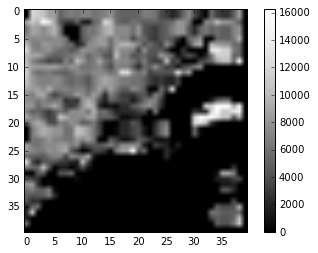

In [137]:
moistureStack = stackDataFromTiles(tiles, SMOSBands.MOISTURE)
showDataset(moistureStack, vmin=0, vmax=16294)

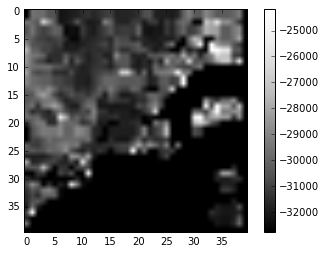

In [138]:
moistureDqxStack = stackDataFromTiles(tiles, SMOSBands.MOISTURE_DQX)
showDataset(moistureDqxStack, vmin=-32768, vmax=-24154)

In [139]:
print "Min moisture", moistureStack.min()
print "Max moisture", moistureStack.max()
print "Min moisture DQX", moistureDqxStack.min()
print "Max moisture DQX", moistureDqxStack.max()

Min moisture -32768
Max moisture 23274
Min moisture DQX -32768
Max moisture DQX -20483
